<a href="https://colab.research.google.com/github/soutrik71/School_of_AI_ERA/blob/main/session7/ERA1S7F3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Same Small model with linited channels as earlier one with 3 conv layer then 1 transition layer then couple of conv layer and then one conv layer with 1,1 kernel and final classfierlayer with 7,7 kernel and 10 classes

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 445976478.64it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 29610289.37it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 114910549.08it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 5046497.69it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([128, 1, 28, 28])
torch.Size([128])


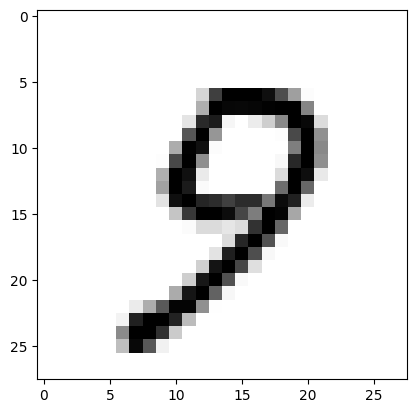

In [8]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

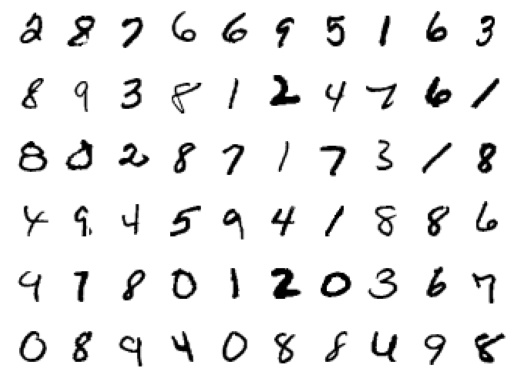

In [9]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),

            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),

            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),


            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1 **
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),


            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK **
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 10, 24, 24]             900
              ReLU-4           [-1, 10, 24, 24]               0
            Conv2d-5           [-1, 20, 22, 22]           1,800
              ReLU-6           [-1, 20, 22, 22]               0
         MaxPool2d-7           [-1, 20, 11, 11]               0
            Conv2d-8           [-1, 10, 11, 11]             200
              ReLU-9           [-1, 10, 11, 11]               0
           Conv2d-10             [-1, 10, 9, 9]             900
             ReLU-11             [-1, 10, 9, 9]               0
           Conv2d-12             [-1, 20, 7, 7]           1,800
             ReLU-13             [-1, 20, 7, 7]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [12]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [13]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.3419646918773651 Batch_id=468 Accuracy=40.66: 100%|██████████| 469/469 [00:18<00:00, 25.70it/s]



Test set: Average loss: 0.2572, Accuracy: 9208/10000 (92.08%)

EPOCH: 1


Loss=0.21424661576747894 Batch_id=468 Accuracy=94.15: 100%|██████████| 469/469 [00:22<00:00, 20.42it/s]



Test set: Average loss: 0.1351, Accuracy: 9566/10000 (95.66%)

EPOCH: 2


Loss=0.059179019182920456 Batch_id=468 Accuracy=96.11: 100%|██████████| 469/469 [00:16<00:00, 28.08it/s]



Test set: Average loss: 0.1006, Accuracy: 9680/10000 (96.80%)

EPOCH: 3


Loss=0.0652863159775734 Batch_id=468 Accuracy=96.98: 100%|██████████| 469/469 [00:15<00:00, 29.91it/s]



Test set: Average loss: 0.0791, Accuracy: 9745/10000 (97.45%)

EPOCH: 4


Loss=0.07619362324476242 Batch_id=468 Accuracy=97.51: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]



Test set: Average loss: 0.0666, Accuracy: 9801/10000 (98.01%)

EPOCH: 5


Loss=0.0915323793888092 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:16<00:00, 29.23it/s]



Test set: Average loss: 0.0606, Accuracy: 9803/10000 (98.03%)

EPOCH: 6


Loss=0.037916991859674454 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]



Test set: Average loss: 0.0586, Accuracy: 9812/10000 (98.12%)

EPOCH: 7


Loss=0.03898780420422554 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:16<00:00, 27.81it/s]



Test set: Average loss: 0.0582, Accuracy: 9827/10000 (98.27%)

EPOCH: 8


Loss=0.004855528008192778 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:16<00:00, 28.34it/s]



Test set: Average loss: 0.0541, Accuracy: 9834/10000 (98.34%)

EPOCH: 9


Loss=0.08844787627458572 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]



Test set: Average loss: 0.0527, Accuracy: 9829/10000 (98.29%)

EPOCH: 10


Loss=0.1078619584441185 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:16<00:00, 29.28it/s]



Test set: Average loss: 0.0487, Accuracy: 9845/10000 (98.45%)

EPOCH: 11


Loss=0.017506808042526245 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:15<00:00, 29.93it/s]



Test set: Average loss: 0.0553, Accuracy: 9816/10000 (98.16%)

EPOCH: 12


Loss=0.060135919600725174 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:16<00:00, 28.38it/s]



Test set: Average loss: 0.0470, Accuracy: 9853/10000 (98.53%)

EPOCH: 13


Loss=0.021332407370209694 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:15<00:00, 29.82it/s]



Test set: Average loss: 0.0498, Accuracy: 9837/10000 (98.37%)

EPOCH: 14


Loss=0.050352003425359726 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 29.10it/s]



Test set: Average loss: 0.0485, Accuracy: 9839/10000 (98.39%)

EPOCH: 15


Loss=0.005768320988863707 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:15<00:00, 29.67it/s]



Test set: Average loss: 0.0460, Accuracy: 9854/10000 (98.54%)

EPOCH: 16


Loss=0.0031925642397254705 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:15<00:00, 29.82it/s]



Test set: Average loss: 0.0476, Accuracy: 9858/10000 (98.58%)

EPOCH: 17


Loss=0.007177641615271568 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 27.25it/s]



Test set: Average loss: 0.0518, Accuracy: 9848/10000 (98.48%)

EPOCH: 18


Loss=0.00789758749306202 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:16<00:00, 28.44it/s]



Test set: Average loss: 0.0441, Accuracy: 9863/10000 (98.63%)

EPOCH: 19


Loss=0.008679848164319992 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:16<00:00, 28.61it/s]



Test set: Average loss: 0.0479, Accuracy: 9843/10000 (98.43%)



Text(0.5, 1.0, 'Test Accuracy')

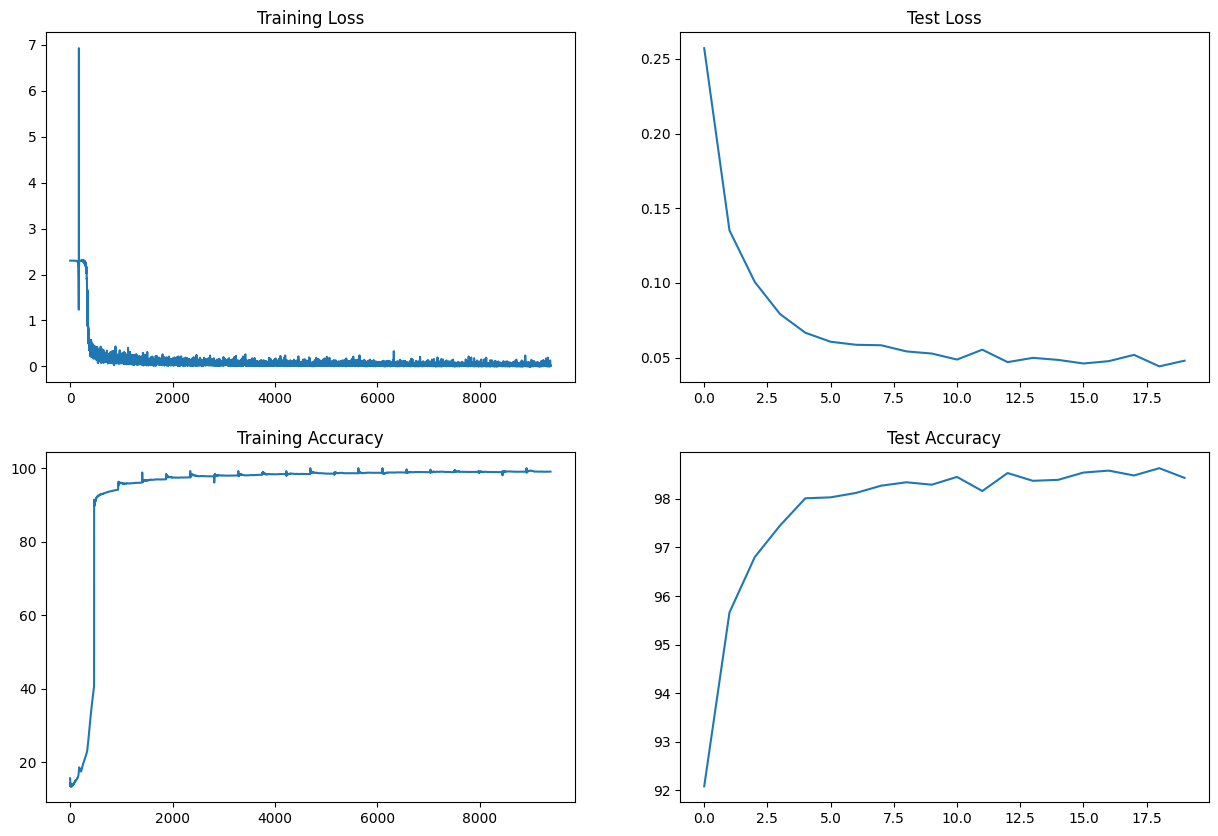

In [15]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Target:
Make the model lighter

Results:
Parameters: 10.7k\
Best Train Accuracy: 99.00\
Best Test Accuracy: 98.98

Analysis:
Good model!\
No over-fitting, model is capable if pushed further